In [229]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import scipy.io

# Load data
mat = scipy.io.loadmat('ML_output\Xy_data_res11Hz150ms.mat')

# Extract variables
X_all = mat['X_all']
y_all = mat['y_all']

# check x_all and y_all
print(f"X_all shape: {X_all.shape}")
print(f"y_all shape: {y_all.shape}")

# If y_all is a MATLAB cell array, convert it properly:
import numpy as np
if y_all.dtype == 'O':
    y_all = [str(y[0]) for y in y_all.squeeze()]

# # normalize the data for each recording, divided by its max value
# X_all = np.array([x / np.max(x) for x in X_all])

# Encode string labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y_all)

# Split into train/test ensure all the category labels are present in both sets
# stratify=y_encoded ensures that the split maintains the same proportion of classes in both sets
# Note: If you have a very small dataset, consider using stratified K-fold cross-validation instead
# to ensure all classes are represented in each fold
# Split the data into training and testing sets
# 80% for training and 20% for testing  
X_train, X_test, y_train, y_test = train_test_split(X_all, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# show dataset
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")



X_all shape: (60, 853)
y_all shape: (60, 1)
X_train shape: (48, 853)
X_test shape: (12, 853)
y_train shape: (48,)
y_test shape: (12,)


In [230]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train[:, :, np.newaxis], dtype=torch.float32)  # Add channel dim
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test[:, :, np.newaxis], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define 1D CNN model
class CNN1D(nn.Module):
    def __init__(self, input_length, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear((input_length - 2) // 2 * 16, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, 1, L)
        x = self.pool(torch.relu(self.conv1(x)))  # (B, C, L)
        x = x.reshape(x.size(0), -1)  # replace view with reshape
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


model = CNN1D(input_length=X_train.shape[1], num_classes=len(le.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(30):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# Evaluate
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

print("1D CNN Accuracy:", accuracy_score(all_labels, all_preds))


Epoch 5: Loss = 0.3713
Epoch 10: Loss = 0.0813
Epoch 15: Loss = 0.0155
Epoch 20: Loss = 0.0050
Epoch 25: Loss = 0.0029
Epoch 30: Loss = 0.0027
1D CNN Accuracy: 0.9166666666666666


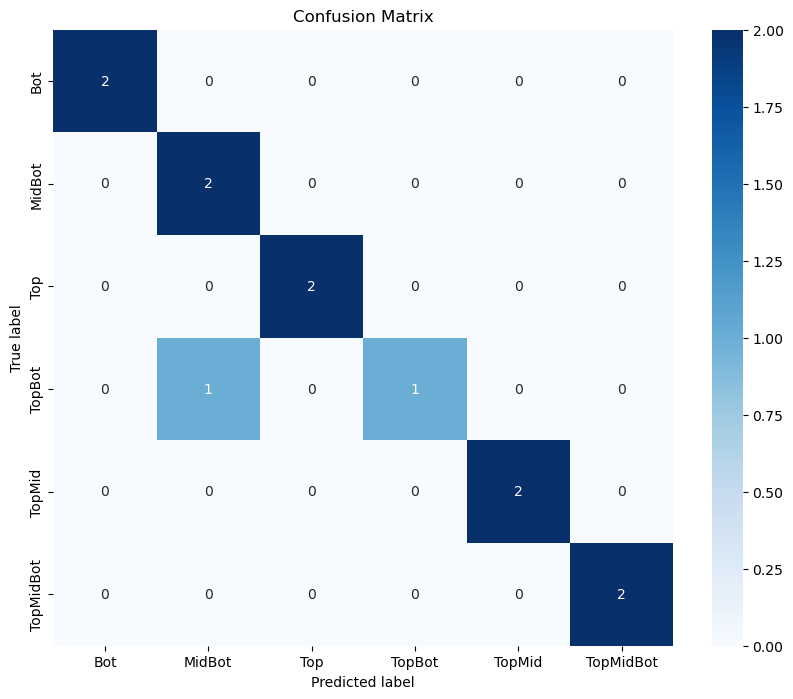

In [231]:
# show the accuracy result in matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

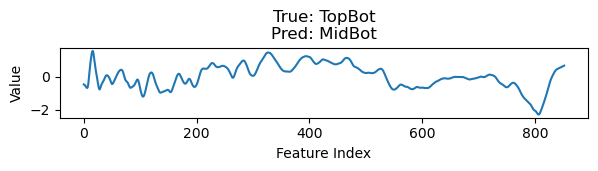

In [232]:
# plot the x feature that has misclassification
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Convert the test data to a DataFrame for easier plotting
X_test_df = pd.DataFrame(X_test, columns=[f'Feature {i}' for i in range(X_test.shape[1])])
X_test_df['True Label'] = y_test
X_test_df['Predicted Label'] = all_preds
misclassified = X_test_df[X_test_df['True Label'] != X_test_df['Predicted Label']]
# Plot the first 10 misclassified samples accompany with their true and predicted labels
plt.figure(figsize=(15, 10))
for i in range(min(10, len(misclassified))):
    plt.subplot(5, 2, i + 1)
    plt.plot(misclassified.iloc[i, :-2].values)
    plt.title(f"True: {le.inverse_transform([misclassified.iloc[i, -2]])[0]}\nPred: {le.inverse_transform([misclassified.iloc[i, -1]])[0]}")
    plt.xlabel('Feature Index')
    plt.ylabel('Value')
    # increase the subplot height
    plt.subplots_adjust(hspace=1.5)


In [233]:
# plot the avg feature of each class 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Convert the test data to a DataFrame for easier plotting
X_test_df = pd.DataFrame(X_test, columns=[f'Feature {i}' for i in range(X_test.shape[1])])
X_test_df['True Label'] = y_test
X_test_df['Predicted Label'] = all_preds
# Calculate the average feature values for each class
avg_features = X_test_df.groupby('True Label').mean().T
# check the shape of the avg_features
print(avg_features.shape)
# set the avg_features index to be integer
avg_features.index = np.arange(avg_features.shape[0])




(854, 6)


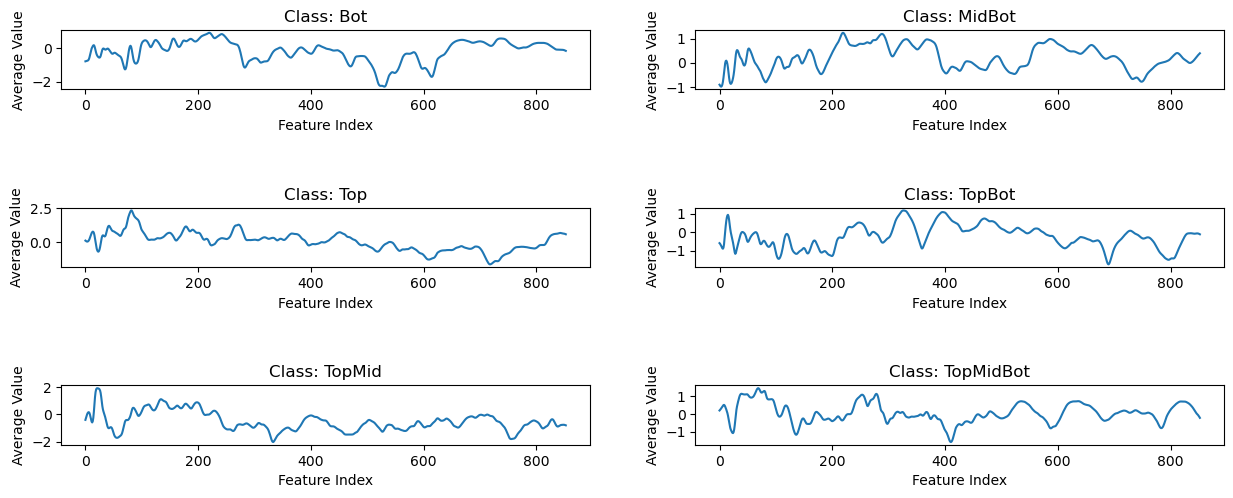

In [234]:
# Plot the average features for each class in time series
plt.figure(figsize=(15, 10))
for i in range(avg_features.shape[1]):
    plt.subplot(5, 2, i + 1)
    plt.plot(avg_features.iloc[:-1, i])
    plt.title(f"Class: {le.inverse_transform([i])[0]}")
    plt.xlabel('Feature Index')
    plt.ylabel('Average Value')
    # increase the subplot height
    plt.subplots_adjust(hspace=2)

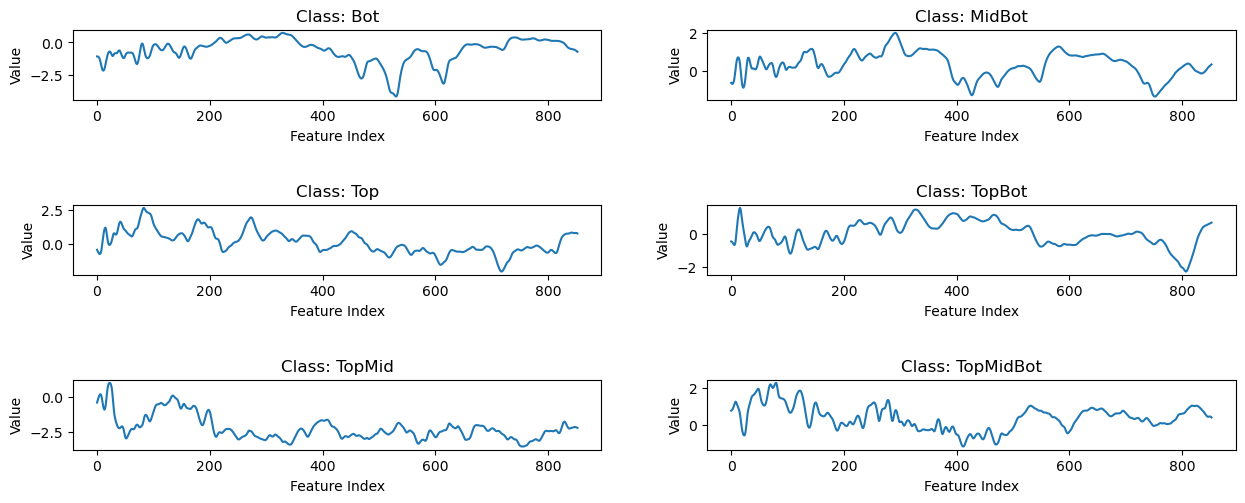

In [235]:
# plot the success classification on each category for one sample
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
# Convert the test data to a DataFrame for easier plotting
X_test_df = pd.DataFrame(X_test, columns=[f'Feature {i}' for i in range(X_test.shape[1])])
X_test_df['True Label'] = y_test
X_test_df['Predicted Label'] = all_preds
# Select a sample from each class
sample_indices = []
for i in range(len(le.classes_)):
    sample_indices.append(X_test_df[X_test_df['True Label'] == i].index[0])
# Plot the features for each class
plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    plt.subplot(5, 2, i + 1)
    plt.plot(X_test_df.iloc[idx, :-2].values)
    plt.title(f"Class: {le.inverse_transform([X_test_df.iloc[idx, -2]])[0]}")
    plt.xlabel('Feature Index')
    plt.ylabel('Value')
    # increase the subplot height
    plt.subplots_adjust(hspace=1.5)

In [236]:
from sklearn.svm import SVC
from sklearn.multiclass import OutputCodeClassifier
from sklearn.metrics import classification_report

# Define SVM base learner
svm = SVC(kernel='linear', probability=True)

# ECOC using OutputCodeClassifier
ecoc = OutputCodeClassifier(estimator=svm, code_size=2.0, random_state=62)
ecoc.fit(X_train, y_train)

# Evaluate
y_pred = ecoc.predict(X_test)
print("SVM + ECOC Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


SVM + ECOC Classification Report:
              precision    recall  f1-score   support

         Bot       1.00      1.00      1.00         2
      MidBot       1.00      1.00      1.00         2
         Top       0.67      1.00      0.80         2
      TopBot       1.00      1.00      1.00         2
      TopMid       0.67      1.00      0.80         2
   TopMidBot       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.72      0.83      0.77        12
weighted avg       0.72      0.83      0.77        12



c:\Users\ZJendex\miniconda3\envs\sens\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ZJendex\miniconda3\envs\sens\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ZJendex\miniconda3\envs\sens\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
